# Naive Bayes Modeling

### Notebook Summary

In this notebook I will use one of the vectorizers that I instantiated in the previous notebook to convert my text data into numeric data, and I will fit a Naive Bayes classification model on a training subset of the data. Then I will test the model against the remaining data to predict whether unseen posts were found on the baseball or Dodgers subreddit. I can then use the model's findings to make inferences about the Dodger fanbase.

In [1]:
import pandas as pd
import json, re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score

%matplotlib inline

## Vectorizing the Text

First I'll load in the feature (`X`) and target (`y`) data from the pre-processing notebook.

In [2]:
with open('../data/X_data.pkl', 'rb') as f:
    X = pickle.load(f)
with open('../data/y_data.pkl', 'rb') as f:
    y = pickle.load(f)

Next I'll split `X` and `y` into training and test sets, with a `random_state` of 42 for reproducibility. And although the sets of baseball and Dodger posts are pretty closely balanced to each other, I'll go ahead and stratify for good measure.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

I will load in the `CountVectorizer` that I instantiated in the previous notebook.

In [5]:
with open('../assets/cvec.pkl', 'rb') as f:
    cvec = pickle.load(f)

And now I will fit the vectorizer to my `X_train` data so it can learn the vocabulary used in those posts. It will then create a matrix of the most significant words used in the `X_train` posts, and I will create a dataframe from that matrix and store it in `X_train_cvec`.

In [6]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns=cvec.get_feature_names())

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['st'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Now I will use the fitted vectorizer to create a matrix of the counts of `X_train`'s most significant words as they appear in `X_test`.

In [7]:
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                            columns=cvec.get_feature_names())

I will display the first five rows of `X_train_cvec` to show that the text data from the Reddit posts now exists in a numeric form, so models can be fit to it.

In [8]:
X_train_cvec.head()

,ab,able,actually,age,agent,ago,al,alex,almost,already,...,worth,would,ws,www,year,years,yesterday,yet,young,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modeling

First I will instantiate a multinomial Naive Bayes classifier, then I will fit it to my now-numeric training data. This classifier is not terribly sophisticated. It will use the features selected by `CountVectorizer` and their counts in each post to calculate the probability of each word's occurrence as it correlates to that post being a member of the positive or negative class (r/Dodgers or r/baseball, respectively).

In [9]:
nb = MultinomialNB()
nb.fit(X_train_cvec, y_train);

The model fits very quickly and it is not computationally intensive. But let's see how well it performs.

In [10]:
print(f'Naive Bayes Train Score :  {nb.score(X_train_cvec, y_train)}')
print(f'Naive Bayes Test Score  :  {nb.score(X_test_cvec, y_test)}')

Naive Bayes Train Score :  0.6956492089470813
Naive Bayes Test Score  :  0.6899867034877775


An accuracy score of around 70% is not very good. But because for my purposes there isn't a real downside to misclassifying one post as another, and because the classes are more or less balanced, accuracy really is the most reasonable score with which to judge the model's strength.

However, before moving on to fit a stronger model, I want to take a look at the predicted probabilities from the Naive Bayes model to see if I can salvage any useful information from it. I'll start by using the model to make predictions on `X_test_cvec` and storing those predictions in a new dataframe `pred_df` alongside the true values of `y_test`.

In [11]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_cvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

Next I'll plot the distribution of the predicted probabilities on a histogram.

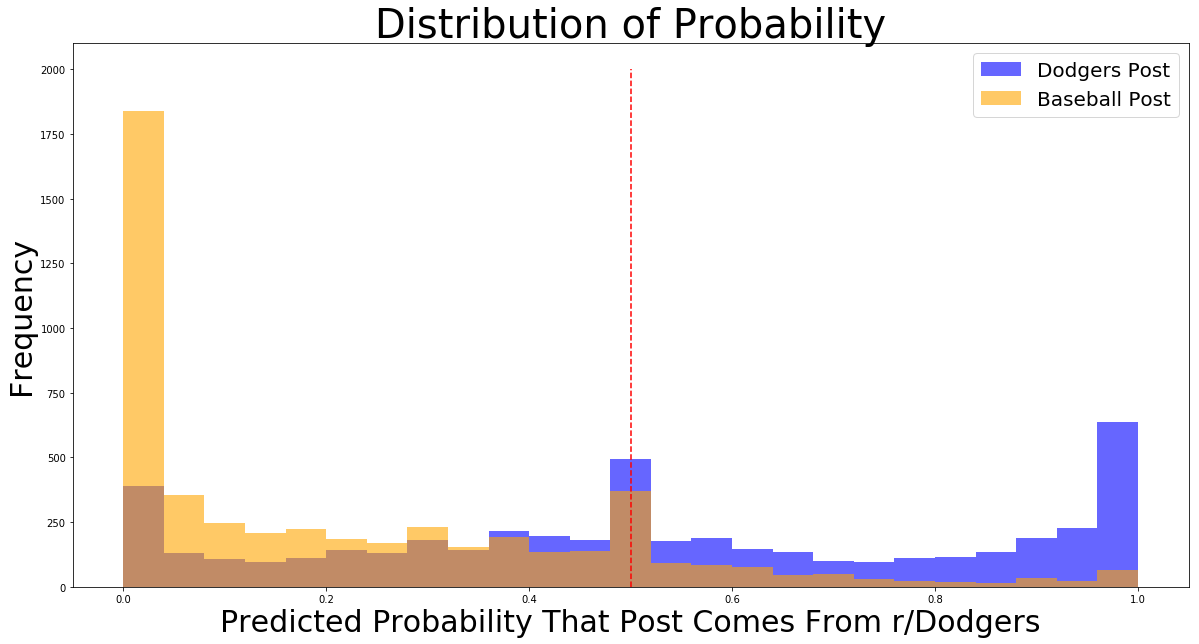

In [12]:
plt.figure(figsize = (20,10))

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Dodgers Post')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Baseball Post')

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 2000,
           color='r',
           linestyle = '--')

plt.title('Distribution of Probability', fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Predicted Probability That Post Comes From r/Dodgers', fontsize=30)

plt.legend(fontsize=20);

plt.savefig('../viz_exports/NB_ProbDist.png');

In the plot above, the blue represents a true instance of a post from r/Dodgers. The orange represents a true instance of a post from r/baseball. Anything plotted to the right of the red midline represents a prediction of r/Dodgers and anything plotted to the left indicates a prediction of r/baseball. So an orange bar on the right half of the plot is a false positive and a blue bar on the left half of the plot is a false negative. Although the accuracy of this model is not very good, from the plot above it does appear that it is doing a good job of not generating false positives by misclassifying r/baseball posts as being from r/Dodgers. I'll calculate the model's precision to verify that.

In [13]:
preds = nb.predict(X_test_cvec)
precision_score(y_test, preds)

0.7937415881561238

This means that 80% of the posts that model predicted as being from r/Dodgers were correct. Given that, I'll check to see what words the model found to be most predictive of a Dodgers classification.

In [14]:
# Adapted from Stack Overflow user piman314
dodgers_prob_sorted = nb.feature_log_prob_[1, :].argsort()
print(np.take(cvec.get_feature_names(), dodgers_prob_sorted[:10]))

['exceed' 'rbaseball' 'roast' 'university' 'guide' 'stove' 'fame'
 'expectations' 'hall' 'age']


From that list of words, it would seem that the r/Dodgers community discusses the hall of fame more often than the general r/baseball community. I will make note of that in my summary report, but otherwise I should try to find a stronger classifying model than this one. I'll begin that process in the next notebook.